# 학습된 모델 저장

- 학습이 완료된 모델을 파일로 저장하여, 이후 추가 학습이나 예측 서비스에 사용할 수 있도록 한다.
- 파이토치(PyTorch)는 **모델의 파라미터만 저장**하는 방법과 **모델의 구조와 파라미터를 모두 저장**하는 두 가지 방식을 제공한다.
- 저장 함수
  - `torch.save(저장할 객체, 저장 경로)`
- 보통 저장 파일의 확장자는 `.pt`나 `.pth`를 사용한다.

## 모델 전체 저장 및 불러오기

- 저장하기
  - `torch.save(model, 저장 경로)`
- 불러오기
  - `load_model = torch.load(저장 경로)`
- 모델 저장 시 **피클(pickle)**을 사용해 직렬화되므로, 모델을 불러오는 실행 환경에도 저장할 때 사용한 클래스 정의가 필요하다.


## 모델의 파라미터만 저장

-   모델을 구성하는 파라미터만 저장한다.
-   모델의 구조는 저장하지 않기 때문에 불러올 때 **모델을 먼저 생성하고 생성한 모델에 불러온 파라미터를 덮어씌운다.**
-   모델의 파라미터는 **state_dict** 형식으로 저장한다.

### state_dict

-   모델의 파라미터 Tensor들을 레이어 단위별로 나누어 저장한 Ordered Dictionary (OrderedDict)
-   `모델객체.state_dict()` 메소드를 이용해 조회한다.
-   모델의 state_dict을 조회 후 저장한다.
    -   `torch.save(model.state_dict(), "저장경로")`
-   생성된 모델에 읽어온 state_dict를 덮어씌운다.
    -   `new_model.load_state_dict(torch.load("state_dict저장경로"))`


## Checkpoint 저장 및 불러오기

- 학습이 끝나지 않은 모델을 저장하고, 나중에 이어서 학습시키려면 모델의 구조와 파라미터뿐만 아니라 optimizer, loss 함수 등 학습에 필요한 객체들도 함께 저장해야 한다.
- 딕셔너리(Dictionary)에 저장하려는 값들을 key-value 쌍으로 구성하여 `torch.save()`를 이용해 저장한다.

```python
# 저장
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_loss
}, "저장경로")

# 불러오기
model = MyModel()
optimizer = optim.Adam(model.parameters())

# 불러온 checkpoint를 이용해 이전 학습 상태 복원
checkpoint = torch.load("저장경로")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
```

In [1]:
# 간단한 모델 정의
import torch
import torch.nn as nn

class MyModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.lr1 = nn.Linear(3, 4)	# 3 X 4 + 4 (weight : input 개수 * output 개수, bias : output개수)
        self.lr2 = nn.Linear(4, 2)	# 4 X 2 + 2
        self.relu = nn.ReLU() 		# activation함수->파라미터가 없는 단순 계산함수. relu(X) = max(X, 0)
    def forward(self, X):
        X = self.lr1(X)
        X = self.relu(X)
        X = self.lr2(X)
        return X

In [3]:
# 모델 생성
model = MyModel()
model

MyModel(
  (lr1): Linear(in_features=3, out_features=4, bias=True)
  (lr2): Linear(in_features=4, out_features=2, bias=True)
  (relu): ReLU()
)

In [20]:
lr1 = model.lr1
lr1

Linear(in_features=3, out_features=4, bias=True)

In [4]:
import os
os.makedirs("saved_models", exist_ok=True)

In [5]:
################################################
#  모델을 저장
################################################
torch.save(model, "saved_models/my_model.pt")

In [12]:
################################################
#  저장된 모델 Load
################################################
load_model = torch.load("saved_models/my_model.pt", weights_only=False)

In [13]:
load_model

MyModel(
  (lr1): Linear(in_features=3, out_features=4, bias=True)
  (lr2): Linear(in_features=4, out_features=2, bias=True)
  (relu): ReLU()
)

In [21]:
load_lr1 = load_model.lr1
lr1.weight

Parameter containing:
tensor([[-0.3651,  0.1232,  0.3460],
        [-0.4825,  0.2392, -0.3930],
        [-0.3216,  0.4554,  0.1087],
        [ 0.3803,  0.1561, -0.1509]], requires_grad=True)

In [8]:
################################################
#  모델에 Layer들을 조회. 모델.instance변수명
################################################
lr_layer = model.lr1
lr_layer

Linear(in_features=3, out_features=4, bias=True)

In [9]:
################################################
#  Layer의 파라미터(weight/bias) 조회
################################################
lr1_weight = lr_layer.weight
lr1_bias = lr_layer.bias

In [10]:
lr1_weight

Parameter containing:
tensor([[-0.3651,  0.1232,  0.3460],
        [-0.4825,  0.2392, -0.3930],
        [-0.3216,  0.4554,  0.1087],
        [ 0.3803,  0.1561, -0.1509]], requires_grad=True)

In [11]:
lr1_bias

Parameter containing:
tensor([-0.3064,  0.1497, -0.5563,  0.4310], requires_grad=True)

In [ ]:
######################################################
# 모델의 파라미터들(weight들, bias들)만 저장/불러오기
# 파라미터들만 가져온거라 뭐 못함 해줄려면 모델에 덮어야함.
######################################################
state_dict = model.state_dict()
state_dict

OrderedDict([('lr1.weight',
              tensor([[-0.3651,  0.1232,  0.3460],
                      [-0.4825,  0.2392, -0.3930],
                      [-0.3216,  0.4554,  0.1087],
                      [ 0.3803,  0.1561, -0.1509]])),
             ('lr1.bias', tensor([-0.3064,  0.1497, -0.5563,  0.4310])),
             ('lr2.weight',
              tensor([[ 0.2344, -0.0167, -0.2647, -0.0400],
                      [ 0.4010, -0.0739, -0.2463,  0.2996]])),
             ('lr2.bias', tensor([ 0.0992, -0.4817]))])

In [23]:
state_dict.keys()

odict_keys(['lr1.weight', 'lr1.bias', 'lr2.weight', 'lr2.bias'])

In [25]:
# dictionary라서 이런식으로 사용 가능
state_dict["lr1.bias"]

tensor([-0.3064,  0.1497, -0.5563,  0.4310])

In [26]:
###################
# state_dict 저장
################### 

torch.save(state_dict, "saved_models/my_model_parameter.pt")

In [27]:
#####################
# state_dict load
#####################
sd = torch.load("saved_models/my_model_parameter.pt")

In [28]:
# load한 state_dict를 모델 파라미터에 적용(덮어 씌운다.)
new_model = MyModel()
new_model.state_dict()

OrderedDict([('lr1.weight',
              tensor([[-0.1443, -0.2442,  0.4039],
                      [ 0.1862, -0.2759,  0.3868],
                      [-0.5097, -0.2812,  0.1197],
                      [-0.4282, -0.1300,  0.4983]])),
             ('lr1.bias', tensor([ 0.3782, -0.3963, -0.1122, -0.5649])),
             ('lr2.weight',
              tensor([[-0.2668, -0.2249, -0.4688,  0.4183],
                      [-0.0299, -0.1588, -0.3859, -0.4993]])),
             ('lr2.bias', tensor([0.3497, 0.1160]))])

In [29]:
new_model.load_state_dict(sd)

<All keys matched successfully>

In [30]:
new_model.state_dict()

OrderedDict([('lr1.weight',
              tensor([[-0.3651,  0.1232,  0.3460],
                      [-0.4825,  0.2392, -0.3930],
                      [-0.3216,  0.4554,  0.1087],
                      [ 0.3803,  0.1561, -0.1509]])),
             ('lr1.bias', tensor([-0.3064,  0.1497, -0.5563,  0.4310])),
             ('lr2.weight',
              tensor([[ 0.2344, -0.0167, -0.2647, -0.0400],
                      [ 0.4010, -0.0739, -0.2463,  0.2996]])),
             ('lr2.bias', tensor([ 0.0992, -0.4817]))])

In [31]:
# torchinof 패키지 설치: 파이토치 모델 구조를 조사해주는 패키지.
!pip install torchinfo

In [32]:
model

MyModel(
  (lr1): Linear(in_features=3, out_features=4, bias=True)
  (lr2): Linear(in_features=4, out_features=2, bias=True)
  (relu): ReLU()
)

In [ ]:
from torchinfo import summary
# model의 내용을 더 상세히 알려주는 모듈.
summary(model)

Layer (type:depth-idx)                   Param #
MyModel                                  --
├─Linear: 1-1                            16
├─Linear: 1-2                            10
├─ReLU: 1-3                              --
Total params: 26
Trainable params: 26
Non-trainable params: 0

In [34]:
# input data 의 shape을 지정하면 각 Layer의 output shape을 출력한다.
summary(model, (100, 3))

Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  [100, 2]                  --
├─Linear: 1-1                            [100, 4]                  16
├─ReLU: 1-2                              [100, 4]                  --
├─Linear: 1-3                            [100, 2]                  10
Total params: 26
Trainable params: 26
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01

# 문제 유형별 MLP 네트워크
- 해결하려는 문제 유형에 따라 출력 Layer의 구조가 바뀐다.
- 딥러닝 구조에서 **Feature를 추출하는 Layer 들을 Backbone** 이라고 하고 **추론하는 Layer들을 Head** 라고 한다. 


> - MLP(Multi Layer Perceptron), DNN(Deep Neural Network), ANN(Artificial Neural Network)
>     -   Fully Connected Layer(nn.Linear)로 구성된 딥러닝 모델
>     -   input feature들 모두에 대응하는 weight들(가중치)을 사용한다.
> 

## Boston Housing Dataset - **Regression(회귀) 문제**

보스턴 주택가격 dataset은 다음과 같은 속성을 바탕으로 해당 타운 주택 가격의 중앙값을 예측하는 문제.

-   CRIM: 범죄율
-   ZN: 25,000 평방피트당 주거지역 비율
-   INDUS: 비소매 상업지구 비율
-   CHAS: 찰스강에 인접해 있는지 여부(인접:1, 아니면:0)
-   NOX: 일산화질소 농도(단위: 0.1ppm)
-   RM: 주택당 방의 수
-   AGE: 1940년 이전에 건설된 주택의 비율
-   DIS: 5개의 보스턴 직업고용센터와의 거리(가중 평균)
-   RAD: 고속도로 접근성
-   TAX: 재산세율
-   PTRATIO: 학생/교사 비율
-   B: 흑인 비율
-   LSTAT: 하위 계층 비율
    <br><br>
-   **Target**
    -   MEDV: 타운의 주택가격 중앙값(단위: 1,000달러)


In [126]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn # layer들을 정의한 module
from torch.utils.data import TensorDataset, DataLoader
import torchinfo

In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [38]:
data_path = "data/boston_hosing.csv"

In [108]:
data = pd.read_csv(data_path)

In [109]:
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [135]:
X = data.drop(columns='MEDV').values
y = data["MEDV"].values.reshape(-1,1)

In [ ]:
# train / test set 분리

X_train, X_test, y_train, y_test = train_test_split(
	X, y, test_size=0.2, random_state=42
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((404, 13), (102, 13), (404, 1), (102, 1))

In [ ]:
# Feature Scaling - Standard Scaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [ ]:
###################################
# Dataset 생성
# X, y가 ndarray type으로 memory에 있는 경우 -> TensorDataset
###################################

trainset = TensorDataset(
	torch.tensor(X_train_scaled, dtype=torch.float32), #model parametor와 type 통일
	torch.tensor(y_train, dtype=torch.float32)
)

testset = TensorDataset(
	torch.tensor(X_test_scaled, dtype=torch.float32),
	torch.tensor(y_test, dtype=torch.float32)
)

In [ ]:
###################################
# DataLoader 생성
###################################

train_loader = DataLoader(
	trainset,
	batch_size= 100,
	shuffle=True,
	drop_last=True
)
test_loader = DataLoader(
	testset,
	batch_size=102
)

In [140]:
# epoch당 step 수
len(train_loader), len(test_loader)

(4, 1)

In [141]:
# input 개수 13, outpu 개수 1
X_train_scaled.shape, y_train.shape

((404, 13), (404, 1))

In [142]:
###################################
# model 정의
###################################

class BostonModel(nn.Module):

	def __init__(self):
		super().__init__()
		self.lr1 = nn.Linear(13, 32)	# 13 : X의 feature 개수
		self.lr2 = nn.Linear(32, 16)
		self.lr3 = nn.Linear(16, 1)		# 1 : 예측할 y의 개수(집값)

	def forward(self, X):
		# lr1 -> ReLU -> lr2 -> ReLU -> lr3
		X = self.lr1(X)
		X = nn.ReLU()(X)	#생성된 객체에다가 콜함수에 X를 넣어주는것
		X = self.lr2(X)
		X = nn.ReLU()(X)
		X = self.lr3(X)
		return X

In [143]:
X_train_scaled.shape, X_train.shape

((404, 13), (404, 13))

In [220]:
boston_model = BostonModel()
torchinfo.summary(boston_model, (100,13))	# (100 : batch size, 13 : feature size)

Layer (type:depth-idx)                   Output Shape              Param #
BostonModel                              [100, 1]                  --
├─Linear: 1-1                            [100, 32]                 448
├─Linear: 1-2                            [100, 16]                 528
├─Linear: 1-3                            [100, 1]                  17
Total params: 993
Trainable params: 993
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.10
Input size (MB): 0.01
Forward/backward pass size (MB): 0.04
Params size (MB): 0.00
Estimated Total Size (MB): 0.05

In [145]:
###################################
# model 정의
###################################
# device로 위치 이동 : model, X, y
# 필요한 객체 생성 : model, loss func, optimizer

boston_model = boston_model.to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.RMSprop(boston_model.parameters(), lr = 0.001)
# optimizer parametor(model의 parametor, neta)

In [146]:
# 학습 : train + validation

train_loss_list = []
valid_loss_list = []

for epoch in range(1000):
	#####################
	# train
	#####################
	boston_model.train()
	train_loss = 0.0	# 현재 epoch loss를 저장할 func
	# step 단위로 학습
	for X_train, y_train in train_loader:
		# 1 batch 학습 == 1 step
		# 1. X, y를 device로 옮기기
		X_train, y_train = X_train.to(device), y_train.to(device)
		
		# 2. model 이용해서 추정
		pred = boston_model(X_train)

		# 3. 검증 : loss cal
		loss = loss_fn(pred, y_train) # (모델 추정값, 정답)

		# 4. gradient cal
		loss.backward()

		# 5. weight/bias update
		optimizer.step()

		# 6. gradient 초기화
		optimizer.zero_grad()

		train_loss += loss.item()
	train_loss /= len(train_loader)	# 1 epoch당 loss 결과 저장.

	#####################
	# test
	#####################
	boston_model.eval()
	valid_loss = 0.0
	with torch.no_grad():
		for X_test, y_test in test_loader:
			# 1. X, y를 device로 옮기기
			X_test, y_test = X_test.to(device), y_test.to(device)

			# 2. 추정
			pred_test = boston_model(X_test)

			# 3. 검증 : loss cal
			valid_loss += loss_fn(pred_test, y_test)
		valid_loss /= len(test_loader)
	
	# 현재 epoch 학습 결과 출력
		print(f"[{epoch+1}/1000] train loss : {train_loss : .5f}, valid loss : {valid_loss :.5f}")
		train_loss_list.append(train_loss)
		valid_loss_list.append(valid_loss)
# 연결해서 학습됨 그래서 다시 돌리면 loss 값 이어짐

[1/1000] train loss :  597.44391, valid loss : 513.96698
[2/1000] train loss :  579.84825, valid loss : 493.54251
[3/1000] train loss :  551.33540, valid loss : 467.91110
[4/1000] train loss :  527.97112, valid loss : 437.49142
[5/1000] train loss :  496.14563, valid loss : 404.08612
[6/1000] train loss :  463.01180, valid loss : 368.96558
[7/1000] train loss :  426.57051, valid loss : 333.37262
[8/1000] train loss :  387.37791, valid loss : 298.48331
[9/1000] train loss :  353.24887, valid loss : 264.41464
[10/1000] train loss :  318.36325, valid loss : 232.16243
[11/1000] train loss :  285.64289, valid loss : 202.34109
[12/1000] train loss :  254.33080, valid loss : 175.29047
[13/1000] train loss :  225.94267, valid loss : 151.42963
[14/1000] train loss :  197.96416, valid loss : 130.62224
[15/1000] train loss :  178.11059, valid loss : 112.87632
[16/1000] train loss :  157.21720, valid loss : 98.01281
[17/1000] train loss :  137.93144, valid loss : 85.88217
[18/1000] train loss :  1

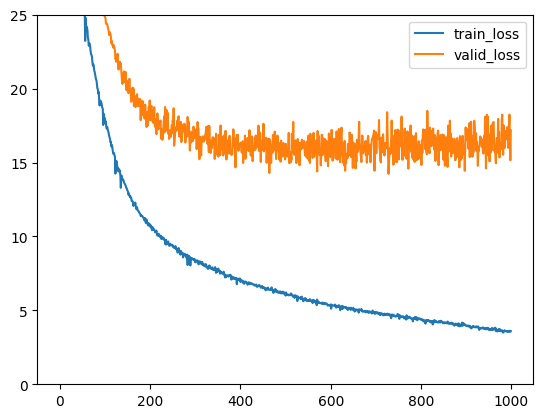

In [148]:
# epoch 별 loss 변화를 시각화
plt.plot(range(1000), train_loss_list, label = "train_loss")
plt.plot(range(1000), valid_loss_list, label = "valid_loss")
plt.ylim(0, 25)
plt.legend()
plt.show()

In [ ]:
#####################
# model save
#####################

torch.save(boston_model, "saved_models/boston_model.pt")

In [152]:
load_boston_model = torch.load("saved_models/boston_model.pt", weights_only=False)

In [ ]:
#####################
# parametor만 save
#####################

torch.save(boston_model.state_dict(), "saved_models/boston_model_state_dict.pt")

In [ ]:
load_sd = torch.load("saved_models/boston_model_state_dict.pt")
load_boston_model2 = BostonModel()
load_boston_model2.load_state_dict(load_sd)

In [157]:
#####################
# 최종 평가
#####################

test_loss = 0.0
with torch.no_grad():
	for X_test, y_test in test_loader:

		# device로 이동
		X_test, y_test = X_test.to(device), y_test.to(device)

		# 추론
		pred_test = load_boston_model(X_test)
		# pred_test = boston_model(X_test)

		# loss cal
		loss_test = loss_fn(pred_test, y_test)
		test_loss += loss_test.item()

	test_loss /= len(test_loader)

print(test_loss)


17.183670043945312


In [158]:
# cnfhs
new_X, _ = trainset[:5]
load_boston_model.eval()
with torch.no_grad():
	new_y = load_boston_model(new_X)


In [159]:
new_y

tensor([[10.5124],
        [19.1049],
        [18.2910],
        [11.3973],
        [18.3974]])

## 분류 (Classification)

### Fashion MNIST Dataset - **다중분류(Multi-Class Classification) 문제**

10개의 범주(category)와 70,000개의 흑백 이미지로 구성된 [패션 MNIST](https://github.com/zalandoresearch/fashion-mnist) 데이터셋.
이미지는 해상도(28x28 픽셀)가 낮고 다음처럼 개별 의류 품목을 나타낸다:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>그림</b> <a href="https://github.com/zalandoresearch/fashion-mnist">패션-MNIST 샘플</a> (Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

- **Feature**이미지는 28x28 크기이며 Gray scale이다.
- **Target**은 총 10개의 class로 구성되어 있으며 각 class의 class 이름은 다음과 같다.

| 레이블 | 클래스       |
|--------|--------------|
| 0      | T-shirt/top |
| 1      | Trousers    |
| 2      | Pullover    |
| 3      | Dress       |
| 4      | Coat        |
| 5      | Sandal      |
| 6      | Shirt       |
| 7      | Sneaker     |
| 8      | Bag         |
| 9      | Ankle boot  |

> #### 학습 도중 모델 저장
>
> - 학습 도중 가장 좋은 성능을 보이는 모델이 나올 수 있다.
> - 학습 도중 모델을 저장하는 방법
>   1. 각 에폭이 끝날 때 마다 모델을 저장한다.
>   2. 한 에폭 학습 후 성능 개선이 있으면 모델을 저장하여 가장 성능 좋은 모델만 저장되도록 한다.
>      - 최고 성능 점수(best score)와 현재 에폭의 성능을 비교하여, 성능이 개선되었을 경우 모델을 저장(덮어쓰기)한다.
>
> #### 조기 종료(Early Stopping)
>
> - 학습 도중 성능 개선이 나타나지 않으면, 중간에 학습을 종료하도록 구현한다.
> - 에폭 수를 충분히 길게 설정한 뒤, 특정 횟수 동안 성능 개선이 없으면 학습을 조기 종료하도록 구현한다.


In [221]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [222]:
####################
# Dataset loading
#####################

fmnist_trainset = datasets.FashionMNIST(
	root= "data",
	train = True,
	download=True,
	transform=transforms.ToTensor()
)

fmnist_testset = datasets.FashionMNIST(
	root= "data",
	train = False,
	download = True,
	transform=transforms.ToTensor()
)

In [185]:
fmnist_trainset, fmnist_testset

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [186]:
idx = 10
fmnist_trainset[idx][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0431,
          0.5569, 0.7843, 0.4157, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.3333, 0.7255, 0.4392, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5961, 0.8392,
          0.8510, 0.7608, 0.9255, 0.8471, 0.7333, 0.5843, 0.5294, 0.6000,
          0.8275, 0.8510, 0.9059, 0.8039, 0.8510, 0.7373, 0.1333, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2588, 0.7255, 0.6510,
          0.7059, 0.7098, 0.7451, 0.8275, 0.8667, 0.7725, 0.5725, 0.7765,
          0.8078, 0.7490, 0.6588, 0.7451, 0.6745, 0.7373, 0.6863, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5294, 0.6000, 0.6275,
          0.6863, 0.7059, 0.6667, 0.7294, 0.7333, 0.7451, 0.7373, 0.7451,
          0.7333, 0.6824, 0.7647, 0.7255, 0.6824, 0.6314,

In [187]:
len(fmnist_trainset)

60000

In [188]:
# trainset -> trainset/validationset으로 분리
# fmnist_trainset, fmnist_validset = torch.utils. data.random_split(
# 	fmnist_trainset, [50000,10000]
# )

fmnist_trainset, fmnist_validset = torch.utils.data.random_split(
    fmnist_trainset, [50000, 10000]
)

In [189]:
len(fmnist_trainset), len(fmnist_testset), len(fmnist_validset)

(50000, 10000, 10000)

In [190]:
fmnist_testset.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [191]:
fmnist_testset.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
#########################
# DataLoader
#########################


train_loader = torch.utils.data.DataLoader(
	fmnist_trainset,
	batch_size = 200,
	shuffle = True,
	drop_last = True
)
valid_loader = torch.utils.data.DataLoader(
	fmnist_validset,
	batch_size = 200,
)
test_loader = torch.utils.data.DataLoader(
	fmnist_testset,
	batch_size = 200,
)

In [223]:
###########################
# model 정의
###########################

class FMNISTModel(nn.Module):

	def __init__(self):
		super().__init__()
		self.lr1 = nn.Linear(784, 512)
		self.lr2 = nn.Linear(512, 256)
		self.lr3 = nn.Linear(256, 128)
		self.lr4 = nn.Linear(128, 64)
		self.lr5 = nn.Linear(64, 10)
		self.relu = nn.ReLU()

	def forward(self, X):
		"""
		X : 입력 tensor - shape : [batch_size, 1, ,28, 28]
		"""
		# 1. flatten -> 3차원 입력을 1차원으로 변환.
		# torch.flatten(X, start_dim=1) #==> ()(X)
		X = nn.Flatten()(X)	# 1축 이후를 flatten

		X = self.lr1(X)
		X = self.relu(X)

		X = self.lr2(X)
		X = self.relu(X)

		X = self.lr3(X)
		X = self.relu(X)

		X = self.lr4(X)
		X = self.relu(X)

		out = self.lr5(X)
		return out


In [215]:
# 모델 구조 확인
m = FMNISTModel()
m.to(device)

FMNISTModel(
  (lr1): Linear(in_features=784, out_features=512, bias=True)
  (lr2): Linear(in_features=512, out_features=256, bias=True)
  (lr3): Linear(in_features=256, out_features=128, bias=True)
  (lr4): Linear(in_features=128, out_features=64, bias=True)
  (lr5): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
)

In [216]:
from torchinfo import summary
summary(m,(200,1,28,28), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
FMNISTModel                              [200, 10]                 --
├─Linear: 1-1                            [200, 512]                401,920
├─ReLU: 1-2                              [200, 512]                --
├─Linear: 1-3                            [200, 256]                131,328
├─ReLU: 1-4                              [200, 256]                --
├─Linear: 1-5                            [200, 128]                32,896
├─ReLU: 1-6                              [200, 128]                --
├─Linear: 1-7                            [200, 64]                 8,256
├─ReLU: 1-8                              [200, 64]                 --
├─Linear: 1-9                            [200, 10]                 650
Total params: 575,050
Trainable params: 575,050
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 115.01
Input size (MB): 0.63
Forward/backward pass size (MB): 1.55
Params size (MB): 2.30
Estimated 

In [217]:
#####################
# 학습
#####################
LR = 0.0001
EPOCHS = 20

fmist_model = FMNISTModel().to(device)
optimizer = torch.optim.Adam(fmist_model.parameters(), lr = LR)
loss_fn = nn.CrossEntropyLoss()
# 다중 분류 loss : categorical crossentropy
## CrossEntropyLoss:
### 1. y 정답을 one hot encoding
### 2. pred 예측값에 softmax를 적용
### 3. categorical crossentropy 계산

In [ ]:
#####################
# 학습
#####################

import time

train_loss_list = []
valid_loss_list = []
valid_acc_list = []

s = time.time()

########## train code 작성
for epoch in range(EPOCHS):




e = time.time()
print(f"학습에 걸린 총 시간 : {e-s}초")

# 성능 확인 후 조기 종료 알고리즘도 추가.

In [228]:
load_fmodel = torch.load("fashion_mnist_model.pt", weights_only=False)
load_fmodel

FMNISTModel(
  (lr1): Linear(in_features=784, out_features=512, bias=True)
  (lr2): Linear(in_features=512, out_features=256, bias=True)
  (lr3): Linear(in_features=256, out_features=128, bias=True)
  (lr4): Linear(in_features=128, out_features=64, bias=True)
  (lr5): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
)

In [227]:
dataloader = torch.utils.data.DataLoader(fmnist_testset, batch_size=50)
x, y = next(iter(dataloader))
x.shape, y.shape

(torch.Size([50, 1, 28, 28]), torch.Size([50]))

In [ ]:
fmnist_testset

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [ ]:
with torch.no_grad():
	pred_logit = load_fmodel(x)
	result = torch.max(pred_logit, dim = -1)

torch.return_types.max(
values=tensor([ 6.6165, 10.2547, 17.5566, 15.8298,  5.5867, 12.9642, 12.3320, 12.8852,
        12.3735,  7.2927,  5.8394,  8.4934,  5.0595,  6.3468,  5.9614,  9.6942,
         8.1569,  6.4463, 11.1379,  5.2048,  3.2624,  4.3939,  7.9788,  5.0826,
        16.5399,  5.5271,  7.8283,  4.4728,  5.8460,  2.2570, 18.4551, 14.1004,
         4.2600,  3.6490, 22.8172,  8.0234,  6.0692,  9.5096,  7.7339, 10.2880,
         6.9833, 14.9835,  5.2897,  5.6794,  8.4235,  5.0249,  3.5945,  8.6214,
         5.4602,  4.6217]),
indices=tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 2, 8, 0, 2, 5, 7, 5,
        1, 2, 6, 0, 9, 3, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 0, 1, 6, 7, 6, 7, 2, 1,
        2, 6]))

In [233]:
result,\
	result.values

(torch.return_types.max(
 values=tensor([ 6.6165, 10.2547, 17.5566, 15.8298,  5.5867, 12.9642, 12.3320, 12.8852,
         12.3735,  7.2927,  5.8394,  8.4934,  5.0595,  6.3468,  5.9614,  9.6942,
          8.1569,  6.4463, 11.1379,  5.2048,  3.2624,  4.3939,  7.9788,  5.0826,
         16.5399,  5.5271,  7.8283,  4.4728,  5.8460,  2.2570, 18.4551, 14.1004,
          4.2600,  3.6490, 22.8172,  8.0234,  6.0692,  9.5096,  7.7339, 10.2880,
          6.9833, 14.9835,  5.2897,  5.6794,  8.4235,  5.0249,  3.5945,  8.6214,
          5.4602,  4.6217]),
 indices=tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 2, 8, 0, 2, 5, 7, 5,
         1, 2, 6, 0, 9, 3, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 0, 1, 6, 7, 6, 7, 2, 1,
         2, 6])),
 tensor([ 6.6165, 10.2547, 17.5566, 15.8298,  5.5867, 12.9642, 12.3320, 12.8852,
         12.3735,  7.2927,  5.8394,  8.4934,  5.0595,  6.3468,  5.9614,  9.6942,
          8.1569,  6.4463, 11.1379,  5.2048,  3.2624,  4.3939,  7.9788,  5.0826,
         16.5399,  5.5

In [236]:
pred_proba = nn.Softmax(dim=-1)(pred_logit)
pred_proba

tensor([[2.1240e-05, 1.3741e-07, 2.1774e-08, 1.3933e-07, 5.7134e-07, 5.3490e-03,
         9.4112e-07, 4.0693e-03, 3.0450e-06, 9.9056e-01],
        [7.7839e-05, 8.9436e-09, 9.9583e-01, 1.6291e-06, 2.2422e-03, 1.9047e-13,
         1.8472e-03, 4.1912e-14, 1.4444e-07, 3.2516e-14],
        [7.1783e-11, 1.0000e+00, 1.9656e-13, 1.3607e-10, 1.3024e-14, 5.8065e-18,
         3.2179e-10, 1.4075e-21, 2.1389e-13, 8.0509e-16],
        [4.9369e-10, 1.0000e+00, 3.1878e-12, 3.9710e-09, 2.1329e-13, 8.4467e-17,
         1.1058e-09, 2.0288e-20, 1.5356e-12, 5.8884e-15],
        [2.2420e-01, 8.2326e-06, 1.1056e-03, 6.8042e-04, 3.6434e-04, 4.2179e-05,
         7.7358e-01, 1.4358e-08, 1.3949e-05, 5.8992e-08],
        [7.3029e-08, 1.0000e+00, 8.7635e-10, 2.0184e-08, 6.9003e-11, 3.8155e-13,
         2.0961e-07, 4.9910e-16, 3.4739e-10, 7.3725e-12],
        [1.7963e-08, 1.9673e-09, 8.7838e-05, 8.1959e-07, 9.9958e-01, 4.0402e-13,
         3.2866e-04, 9.6261e-13, 2.6871e-10, 3.9642e-13],
        [1.9375e-06, 1.6715

In [238]:
result = torch.max(pred_proba, dim=-1)
result

torch.return_types.max(
values=tensor([0.9906, 0.9958, 1.0000, 1.0000, 0.7736, 1.0000, 0.9996, 0.9994, 1.0000,
        0.9984, 0.9165, 0.9999, 0.5519, 0.9979, 0.8424, 1.0000, 0.9948, 0.8746,
        1.0000, 0.9471, 0.7399, 0.6761, 0.9997, 0.9855, 1.0000, 0.7187, 0.9264,
        0.8197, 0.9780, 0.4040, 1.0000, 1.0000, 0.9744, 0.8790, 1.0000, 0.9943,
        0.9982, 0.9999, 0.9995, 0.9999, 0.9350, 1.0000, 0.8963, 0.9547, 0.9171,
        0.9510, 0.7934, 0.9999, 0.4417, 0.8384]),
indices=tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 2, 8, 0, 2, 5, 7, 5,
        1, 2, 6, 0, 9, 3, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 0, 1, 6, 7, 6, 7, 2, 1,
        2, 6]))

In [242]:
def predict(model, x):
	with torch.no_grad():
		pred = model(x)
		pred_proba = nn.Softmax(dim=-1)(pred)
		result = torch.max(pred_proba, dim=-1)
		return [(idx.item(),proba.item()) for idx, proba in zip(result.indices, result.values)]

In [244]:
result = predict(load_fmodel, x)
result

[(9, 0.9905555844306946),
 (2, 0.9958310723304749),
 (1, 1.0),
 (1, 1.0),
 (6, 0.7735845446586609),
 (1, 0.9999996423721313),
 (4, 0.9995827078819275),
 (6, 0.9994454979896545),
 (5, 0.9999996423721313),
 (7, 0.9984103441238403),
 (4, 0.9164848923683167),
 (5, 0.9999071359634399),
 (7, 0.5518661737442017),
 (3, 0.9979277849197388),
 (4, 0.8423774838447571),
 (1, 0.9999840259552002),
 (2, 0.994787335395813),
 (2, 0.8745715022087097),
 (8, 0.9999815225601196),
 (0, 0.9470783472061157),
 (2, 0.7399144768714905),
 (5, 0.6761211156845093),
 (7, 0.9997068047523499),
 (5, 0.9854647517204285),
 (1, 1.0),
 (2, 0.7186679840087891),
 (6, 0.9263898134231567),
 (0, 0.819709300994873),
 (9, 0.9779600501060486),
 (3, 0.4039537310600281),
 (8, 1.0),
 (8, 0.9999992847442627),
 (3, 0.9743779897689819),
 (3, 0.8789570927619934),
 (8, 1.0),
 (0, 0.9943010807037354),
 (7, 0.9981901049613953),
 (5, 0.9999299049377441),
 (7, 0.9994679093360901),
 (9, 0.9998764991760254),
 (0, 0.9349932670593262),
 (1, 1.0),


### 위스콘신 유방암 데이터셋 - **이진분류(Binary Classification) 문제**

-   **이진 분류 문제 처리 모델의 두가지 방법**
    1. positive(1)일 확률을 출력하도록 구현
        - output layer: units=1, 
		- activation=**sigmoid**
        - loss: **binary_crossentropy**
    2. negative(0)일 확률과 positive(1)일 확률을 출력하도록 구현 => 다중분류 처리 방식으로 해결
        - output layer: units=2, activation='softmax', y(정답)은 one hot encoding 처리
        - loss: categorical_crossentropy
-   위스콘신 대학교에서 제공한 종양의 악성/양성여부 분류를 위한 데이터셋
-   Feature
    -   종양에 대한 다양한 측정값들
-   Target의 class
    -   0 - malignant(악성종양)
    -   1 - benign(양성종양)


In [272]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [273]:
# Dataset
X, y = load_breast_cancer(return_X_y=True)
print(y.shape)
y = y.reshape(-1, 1)	# shpae 맞게
print(y.shape)
# X.shape, y.shape, X.dtype
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=0)

(569,)
(569, 1)


In [274]:
# 전처리
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [275]:
# class name <-> class index
classes = np.array(["악성종양", "양성종양"])
class_to_idx = {"악성종양":0, "양성종양":1}

In [276]:
# Dataset
## 모델의 weight, bias -> float32. X, y는 weight, bias와 계산을 하게 되기 때문에 타입을 맞춰준다.
trainset = TensorDataset(
    torch.tensor(X_train_scaled, dtype=torch.float32),  
    torch.tensor(y_train, dtype=torch.float32)
)
testset = TensorDataset(
    torch.tensor(X_test_scaled, dtype=torch.float32), 
    torch.tensor(y_test, dtype=torch.float32)
)

In [277]:
trainset.classes = classes
trainset.class_to_idx = class_to_idx

In [278]:
# DataLoader
train_loader = DataLoader(trainset, batch_size=200, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=100)

In [279]:
X_train_scaled.shape

(426, 30)

In [280]:
######### 모델 정의
class BreastCancerModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.lr1 = nn.Linear(30, 32)
        self.lr2 = nn.Linear(32, 8)
        self.lr3 = nn.Linear(8, 1) # 출력 Layer 처리하는 함수. out_features=1 : positive일 확률.
        self.relu = nn.ReLU()
        self.logistic = nn.Sigmoid() # 입력값을 0 ~ 1 사이 실수로 반환. 

    def forward(self, X):
        X = self.lr1(X)
        X = self.relu(X)
        X = self.lr2(X)
        X = self.relu(X)
        # 출력 Layer
        output = self.lr3(X)
        output = self.logistic(output)
        return output

In [281]:
b_model = BreastCancerModel()
b_model

BreastCancerModel(
  (lr1): Linear(in_features=30, out_features=32, bias=True)
  (lr2): Linear(in_features=32, out_features=8, bias=True)
  (lr3): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
  (logistic): Sigmoid()
)

In [282]:
from torchinfo import summary
summary(b_model, (10, 30), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
BreastCancerModel                        [10, 1]                   --
├─Linear: 1-1                            [10, 32]                  992
├─ReLU: 1-2                              [10, 32]                  --
├─Linear: 1-3                            [10, 8]                   264
├─ReLU: 1-4                              [10, 8]                   --
├─Linear: 1-5                            [10, 1]                   9
├─Sigmoid: 1-6                           [10, 1]                   --
Total params: 1,265
Trainable params: 1,265
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01

In [283]:
# dummy data로 출력
dummy_x = torch.randn(10, 30)
# dummy_x.shape
result = b_model(dummy_x)
print(result.shape)
result

torch.Size([10, 1])


tensor([[0.4717],
        [0.4711],
        [0.4917],
        [0.4779],
        [0.4807],
        [0.4786],
        [0.4804],
        [0.4732],
        [0.5187],
        [0.4715]], grad_fn=<SigmoidBackward0>)

In [284]:
(result > 0.5).type(torch.int32)  # bool -> int (True: 1, False: 0)

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0]], dtype=torch.int32)

In [285]:
lr = 0.001
epochs = 1000
######## 학습(train)
b_model = b_model.to(device)
optimizer = optim.Adam(b_model.parameters(), lr=lr)
loss_fn = nn.BCELoss()   # 함수이름: binary crossentropy

In [286]:
import time

### 모델 학습(train) 로직 작성
#### 검증 결과 -> train loss, valid_loss, valid_accuracy
### 모델 성능이 개선될 때 마다 저장.
### 조기종료 - 10 epoch 동안 성능 개선이 없으면 조기종료

save_path = "saved_models/bc_model.pt"
best_score = torch.inf   # validation loss 기준으로 저장/조기종료 여부 확인.
patience = 10
trigger_cnt = 0

train_losses, valid_losses, valid_acces = [], [], []

s = time.time()
for epoch in range(epochs):
    ################### train #######################
    b_model.train()
    train_loss = 0.0
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        pred = b_model(X_train)  # positive일 확률
        loss = loss_fn(pred, y_train)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    ################### validation ##################
    b_model.eval()
    valid_loss = valid_acc = 0.0
    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            pred_test = b_model(X_test) # positive일 확률
            valid_loss += loss_fn(pred_test, y_test).item()
            #  이진 분류에서 accuracy
            valid_acc += torch.sum((pred_test > 0.5).type(torch.int32) == y_test).item()
        valid_loss /= len(test_loader)
        valid_acc /= len(test_loader.dataset)
        valid_losses.append(valid_loss)
        valid_acces.append(valid_acc)
    
    log_template = "[{:04d}/{}] train loss: {}, valid loss: {}, valid accuracy: {}"
    print(log_template.format(epoch+1, epochs, train_loss, valid_loss, valid_acc))
    # 모델 저장, 조기종료
    if valid_loss <  best_score: # 성능 개선
        print(f">>>>>> {epoch+1}에서 성능이 개선되어 저장합니다. {valid_loss}")
        torch.save(b_model, save_path)
        best_score = valid_loss
        trigger_cnt = 0
    else:
        trigger_cnt += 1
        if patience == trigger_cnt:
            print(f"{epoch+1} 에폭에서 조기종료 합니다. {best_score}에서 개선되지 않음.")
            break
    
e = time.time()
print("걸린시간(초):", e-s)

[0001/1000] train loss: 0.7247967720031738, valid loss: 0.7179374694824219, valid accuracy: 0.34265734265734266
>>>>>> 1에서 성능이 개선되어 저장합니다. 0.7179374694824219
[0002/1000] train loss: 0.7158568501472473, valid loss: 0.7096849679946899, valid accuracy: 0.3776223776223776
>>>>>> 2에서 성능이 개선되어 저장합니다. 0.7096849679946899
[0003/1000] train loss: 0.7067461609840393, valid loss: 0.701328694820404, valid accuracy: 0.3916083916083916
>>>>>> 3에서 성능이 개선되어 저장합니다. 0.701328694820404
[0004/1000] train loss: 0.6979152262210846, valid loss: 0.6929545104503632, valid accuracy: 0.46853146853146854
>>>>>> 4에서 성능이 개선되어 저장합니다. 0.6929545104503632
[0005/1000] train loss: 0.6881288588047028, valid loss: 0.6845139265060425, valid accuracy: 0.5384615384615384
>>>>>> 5에서 성능이 개선되어 저장합니다. 0.6845139265060425
[0006/1000] train loss: 0.6804743409156799, valid loss: 0.6758750975131989, valid accuracy: 0.5944055944055944
>>>>>> 6에서 성능이 개선되어 저장합니다. 0.6758750975131989
[0007/1000] train loss: 0.6698730289936066, valid loss: 0.

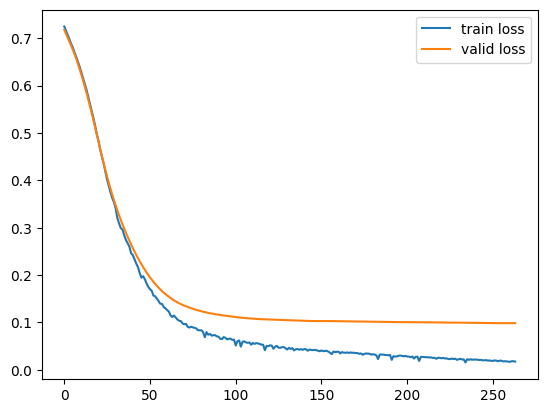

In [287]:
## loss, acc 시각화

plt.plot(range(len(train_losses)), train_losses, label="train loss")
plt.plot(range(len(valid_losses)), valid_losses, label="valid loss")
plt.legend()
plt.show()

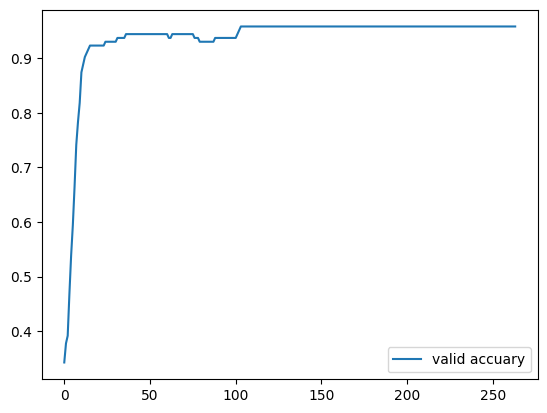

In [290]:
plt.plot(range(len(valid_acces)),valid_acces, label="valid accuary")
plt.legend()
plt.show()

In [292]:
best_model = torch.load(save_path,weights_only=False)
best_model

BreastCancerModel(
  (lr1): Linear(in_features=30, out_features=32, bias=True)
  (lr2): Linear(in_features=32, out_features=8, bias=True)
  (lr3): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
  (logistic): Sigmoid()
)

In [302]:
def predict_bc(model, X, device=device):
    # model로 X를 추론한 결과를 반환
    # label, 확률
    result = []
    with torch.no_grad():
        pred_proba = model(X)	# [[0.8], [0.1], ...]
        pred_class = (pred_proba > 0.5).type(torch.int32)	# [[1], [0], ...]
        for class_index, proba in zip(pred_class, pred_proba):
            # print(class_index, proba if class_index.item() == 1 else 1-proba)
            result.append((class_index.item(), proba if class_index.item() == 1 else 1-proba))
            # proba if class_index.item() == 1 else 1-proba
            ## proba : 양성일 확률
            # model이 예측한 class가 1 : proba값을 확률로 사용
            # model이 예측한 class가 0 : 1-proba값을 확률로 사용(양성 확률을 음성 확률로 변환)
        return result

In [303]:
new_data = torch.tensor(X_test_scaled[:5], dtype=torch.float32)
# print(new_data.shape)
result = predict_bc(best_model, new_data, device)

In [304]:
result

[(1, tensor([0.9991])),
 (0, tensor([0.9999])),
 (0, tensor([0.9995])),
 (1, tensor([0.9999])),
 (0, tensor([0.9960]))]

# 모델 유형별 구현 정리

## 공통

-   Input layer(첫번째 Layer)의 in_features
    -   **입력데이터의 feature(속성) 개수**에 맞춰준다.
-   Hidden layer 수
    -   경험적(art)으로 정한다.
    -   Hidden layer에 Linear를 사용하는 경우 보통 feature 수를 줄여 나간다. (핵심 특성들을 추출해나가는 과정의 개념.)

## 회귀 모델

-   output layer의 출력 unit개수(out_features)
    -   정답의 개수
    -   ex
        -   집값: 1
        -   아파트가격, 단독가격, 빌라가격: 3 => y의 개수에 맞춘다.
-   출력 Layer에 적용하는 activation 함수
    -   일반적으로 **None**
    -   값의 범위가 설정되 있고 그 범위의 값을 출력하는 함수가 있을 경우
        -   ex) 0 ~ 1: logistic(Sigmoid), -1 ~ 1: hyperbolic tangent(Tanh)
-   loss함수
    -   MSELoss
-   평가지표
    -   MSE, RMSE, R square($R^2$)

## 다중분류 모델

-   output layer의 unit 개수
    -   정답 class(고유값)의 개수
-   출력 Layer에 적용하는 activation 함수
    -   Softmax: 클래스별 확률을 출력
-   loss함수
    -   **categrocial crossentropy**
    -   파이토치 함수
        -   **CrossEntropyLoss** = NLLLoss(정답) + LogSoftmax(모델 예측값)
        -   **NLLLoss**
            -   정답을 OneHot Encoding 처리 후 Loss를 계산한다.
            -   입력으로 LogSoftmax 처리한 모델 예측값과 onehot encoding 안 된 정답을 받는다.
        -   **LogSoftmax**
            -   입력값에 Softmax 계산후 그 Log를 계산한다.
                -   NLLLoss의 모델 예측값 입력값으로 처리할 때 사용한다.

```python
pred = model(input)
loss1 = nn.NLLLoss(nn.LogSoftmax(dim=-1)(pred), y)
# or
loss2 = nn.CrossEntropyLoss()(pred, y)
```

## 이진분류 모델

-   output layer의 unit 개수
    -   1개 (positive일 확률)
-   출력 Layer에 적용하는 activation 함수
    -   Sigmoid(Logistic)
-   loss 함수
    -   **Binary crossentropy**
    -   파이토치 함수: **BCELoss**
